# Data Insight Generation
The purpose of this project is to gain insight into how Canadians consume digital media.  In particular, we are interested in understanding:

1. From what locations are users consuming content?
2. From what type of device are users consuming content?
3. From what content areas are users consuming content?

This is an initial look at the data and is by no means intended to be an exhaustive analysis of the dataset.  The data found within this notebook represents events occurring between the hour of 23:00-23:59 on 2018-04-01.

In [141]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import seaborn as sns

from collections import defaultdict

sns.set_style("whitegrid")

# create a colour pallette
cmap_palette = sns.color_palette("hls", 13)
sns.set_palette(cmap_palette)

# define a single colour that can be used for various plots
deep_blue = sns.xkcd_rgb["denim blue"]

## 1. Data Import
Prior to this analysis, data was imported and cleansed.  Details around this process can be found in the Data Import & Cleaning notebook. 

In [142]:
# read data
df = pd.read_csv('../data/processed/processed_data.csv', index_col=0, parse_dates=['client_event_time','client_upload_time','server_received_time','server_upload_time','user_creation_time'])

In [143]:
# take a peak at the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100527 entries, caf8305b-40e4-41e0-8692-5d6af97ec682 to 9fd94874-f301-45b9-9cfd-9b625b6ae6e0
Data columns (total 31 columns):
schema                   100527 non-null int64
amplitude_id             100527 non-null int64
app                      100527 non-null int64
city                     99616 non-null object
client_event_time        100527 non-null datetime64[ns]
client_upload_time       100527 non-null datetime64[ns]
country                  100515 non-null object
event_id                 100527 non-null int64
event_time               100527 non-null object
event_type               100527 non-null object
is_attribution_event     100527 non-null bool
language                 100476 non-null object
library                  100527 non-null object
os_name                  100134 non-null object
os_version               99038 non-null object
platform                 100527 non-null object
processed_time           100527 non-null object
regio

## 2. Events Detail Overview
Looking further into the type of events captured and when they were captured.

### What type of events are contained within the dataset? 

In [144]:
df.event_type.value_counts()

LOADED           67664
READ             24876
session_start     2906
OPENED            1721
STREAMED          1640
LOADED MORE        554
session_end        388
CLOSED             278
SEARCHED           189
NEXT               116
COMMENTED           69
SELECTED            66
PREVIOUS            21
SIGNED IN           19
SCANNED              5
SIGNED OUT           5
SUBMITTED            4
OPTED IN             4
SUBSCRIBED           2
Name: event_type, dtype: int64

### When were events captured throughout the hour? 

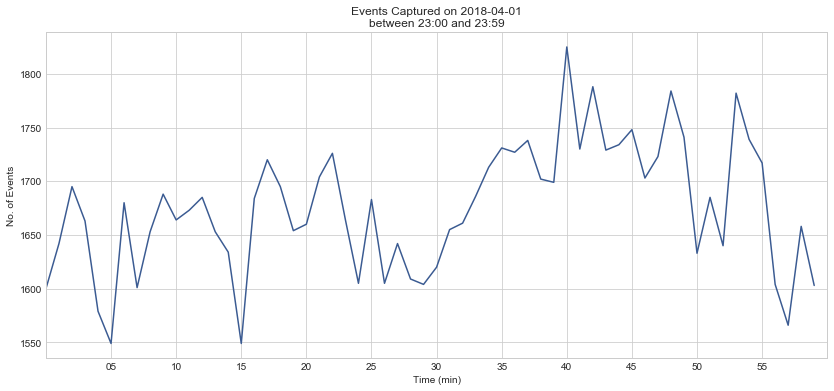

In [145]:
# get data
data = df.groupby(pd.Grouper(key='client_event_time', freq='T')).event_id.count()

# get values
x = list(data.index)
y = data.values

# create figure
fig, ax = plt.subplots(figsize=(14, 6))

# create plot
plt.plot(x, y, color=deep_blue)

# set xtick label style
minutes = mdates.MinuteLocator(interval=5)  
minute_fmt = mdates.DateFormatter('%M')

# set xtick formatters
ax.xaxis.set_major_locator(minutes)
ax.xaxis.set_major_formatter(minute_fmt)

# set min and mix for xticks
min_date = min(df.client_event_time)
max_date = max(df.client_event_time)
ax.set_xlim(min_date, max_date)

# set titles
plt.title('Events Captured on 2018-04-01\nbetween 23:00 and 23:59')
plt.xlabel('Time (min)')
plt.ylabel('No. of Events')

plt.savefig('../figures/event_distribution.png')

plt.show()


### What is the average number of events per minute? 

In [146]:
df.groupby(pd.Grouper(key='client_event_time', freq='T')).event_id.count().mean()

1675.45

In [147]:
max(df.groupby(pd.Grouper(key='client_event_time', freq='T')).event_id.count())

1825

In [148]:
min(df.groupby(pd.Grouper(key='client_event_time', freq='T')).event_id.count())

1549

## 3.  Content Consumption By Location

## Where are people accessing content from?

In [149]:
# display how many countries are captured
len(df.country.unique())

109

In [150]:
# display a list of countries 
df.country.sort_values().unique()

array(['Algeria', 'Argentina', 'Australia', 'Austria', 'Bahamas',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil',
       'Brunei', 'Cambodia', 'Cameroon', 'Canada',
       'Caribbean Netherlands', 'Cayman Islands', 'Chile', 'China',
       'Colombia', 'Costa Rica', 'Cuba', 'Curaçao', 'Czech Republic',
       'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Fiji', 'Finland', 'France', 'Germany', 'Ghana', 'Greece',
       'Guatemala', 'Guyana', 'Honduras', 'Hong Kong', 'Hungary',
       'Iceland', 'India', 'Indonesia', 'Iran', 'Ireland', 'Isle of Man',
       'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan',
       'Kenya', 'Kuwait', 'Lebanon', 'Macedonia', 'Malaysia', 'Mauritius',
       'Mexico', 'Morocco', 'Nepal', 'Netherlands', 'New Zealand',
       'Nicaragua', 'Nigeria', 'Norway', 'Oman', 'Pakistan', 'Panama',
       'Papua New Guinea', 'Paraguay', 'P

## How many active users per country? 
We assume that amplitude_id represents a unique user id (I'm thinking about this as if it is a cookie id assigned to a user while browsing).  With this in mind, we can count the unique number of amplitude_ids in the dataset to get an idea of how many unique users are consuming content per country. 

In [151]:
df.groupby('country').amplitude_id.nunique().sort_values(ascending=False).head(20)

country
Canada            40448
United States      2582
France              278
Australia           165
United Kingdom      160
Mexico              105
Japan                68
Ireland              66
Brazil               52
Malaysia             45
Philippines          45
New Zealand          33
Germany              29
Singapore            21
Jamaica              21
Netherlands          19
Thailand             18
Hong Kong            17
South Korea          17
India                16
Name: amplitude_id, dtype: int64

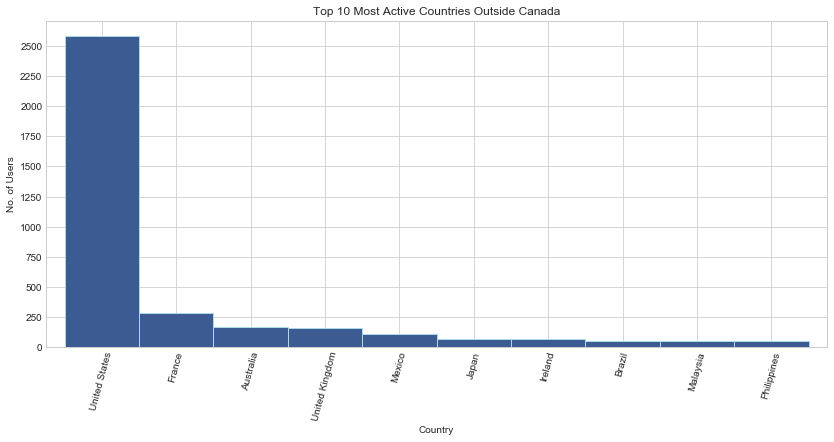

In [152]:
# find top 10 countries outside of canada
top_10_countries = df[df.country != 'Canada'].groupby('country').amplitude_id.nunique().sort_values(ascending=False)[:10]

# create plot
top_10_countries.plot.bar(figsize=(14, 6), width=1, color=deep_blue, edgecolor='lightblue')

# grab axis object
ax = plt.gca()

# create yaxis labels & set them
yaxis_ticks = np.arange(0, max(top_10_countries.round(decimals=-2)),250) 
ax.set_yticks(yaxis_ticks)
plt.xticks(rotation='75')

# set titles
plt.title('Top 10 Most Active Countries Outside Canada')
plt.xlabel('Country')
plt.ylabel('No. of Users')

plt.savefig('../figures/active_users_per_country.png')

plt.show()

## Within Canada, what is the breakdown of active users per province? 

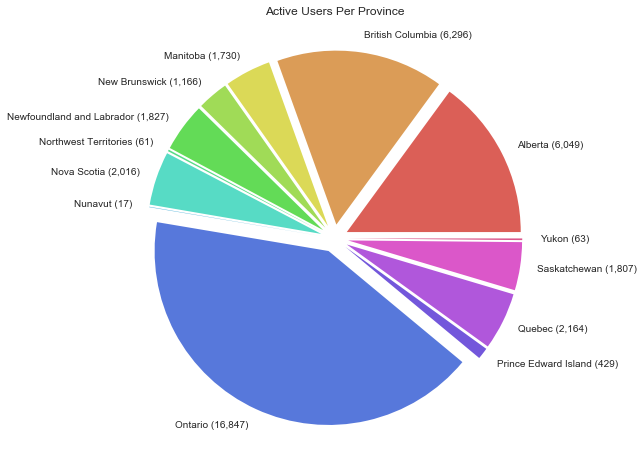

In [153]:
# get data
data_by_users_provice = df[df.country == 'Canada'].groupby('region').amplitude_id.nunique().sort_index()

# Break out values & labels
data_values = data_by_users_provice.values
data_labels = ['{0} ({1:,})'.format(k, v) for k, v in zip(data_by_users_provice.index, data_by_users_provice.values)]
explode = [0.08 for i in data_labels]

# create plot
fig, ax = plt.subplots(figsize=(14,8))

# generate plot
patches, text = ax.pie(data_values, radius=1,explode=explode, labels=data_labels)
ax.set(aspect='equal')

# create legend
#plt.legend(patches, data_labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=9)

# add title
plt.title('Active Users Per Province')

plt.savefig('../figures/active_users_per_province.png')

plt.show()

## What is the breakdown of events per minute by province? 

In [154]:
# define our data - grouped by event time & region
events = df[df.country=='Canada'].groupby([pd.Grouper(key='client_event_time',freq='T'),'region']).event_id.count()

items = defaultdict(list)

# get index values 
level_1_index = events.index.get_level_values(0).sort_values().unique()
level_2_index = events.index.get_level_values(1).sort_values().unique()

# we are going to create a stacked plot.  This simply organizes the data into the format that allows
# the plot to display correctly
for index_1 in level_1_index:
    for index_2 in level_2_index:
               
        # we check to see if there were any events for the given location at the given minute.  
        # if no events occurred, we append 0.
        if len(events.loc[(events.index.get_level_values(0)==index_1) & 
                          (events.index.get_level_values(1)==index_2)]) > 0:
            value = events.loc[(events.index.get_level_values(0)==index_1) & 
                               (events.index.get_level_values(1)==index_2)].values[0]
        else:
            value = 0
            
        items[index_2].append(value)

# Here we actually get our data for the x & y values
x = level_1_index
y = []
for index_2 in level_2_index:
        y.append(items[index_2])

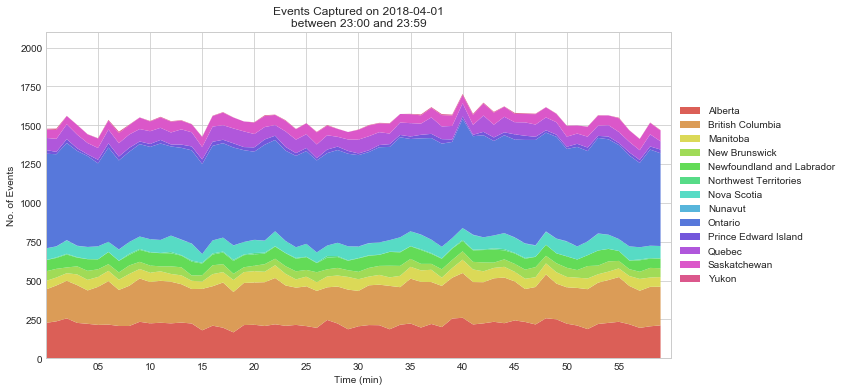

In [155]:
# create plot
fig, ax = plt.subplots(figsize=(14, 6))
    
# setup label formats
minutes = mdates.MinuteLocator(interval=5) 
minute_fmt = mdates.DateFormatter('%M')
ax.xaxis.set_major_locator(minutes)
ax.xaxis.set_major_formatter(minute_fmt)

# limit the xticks to be within the 23 hour
min_date = min(df.client_event_time)
max_date = max(df.client_event_time)
ax.set_xlim(min_date, max_date)

# plot
plt.stackplot(x,y, labels = level_2_index)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(top=2100)

# set titles
plt.title('Events Captured on 2018-04-01\nbetween 23:00 and 23:59')
plt.xlabel('Time (min)')
plt.ylabel('No. of Events')

plt.savefig('../figures/event_distribution_per_province.png')

plt.show()


## What languages are users consuming content?

In [156]:
# how many different languages
data_by_language = df.groupby('language').amplitude_id.nunique().sort_values(ascending=False)
len(data_by_language)

28

In [157]:
# print out languages
data_by_language

language
English       43934
French          249
Chinese          54
Spanish          40
Portuguese       40
German           21
Japanese         18
Korean           11
Russian          10
Vietnamese        7
Italian           7
Arabic            6
Swedish           4
Danish            4
Norwegian         4
Indonesian        3
Hungarian         3
Persian           3
Finnish           3
Dutch             3
Polish            3
Czech             3
Hebrew            2
Greek             2
Ukrainian         2
Turkish           2
Serbian           1
Romanian          1
Name: amplitude_id, dtype: int64

## What are the top 10 cities that consume content in Canada?

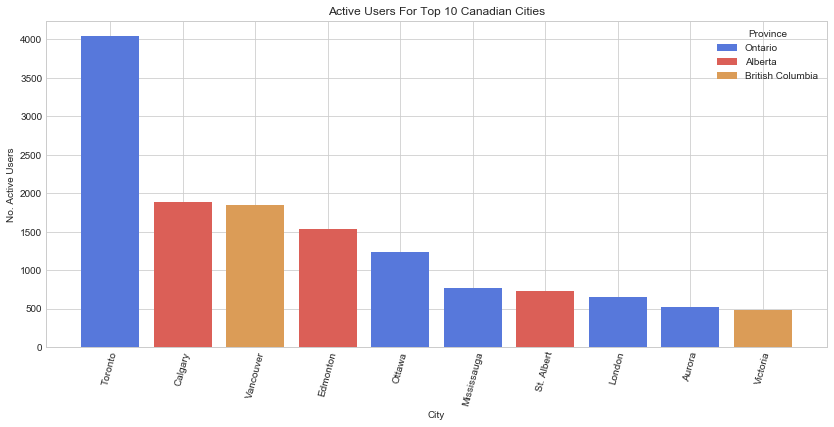

In [83]:
# generate data
data = df[(df.country=='Canada') & (df.region.isin(['Ontario', 'British Columbia', 'Alberta']))].groupby(['region', 'city']).amplitude_id.nunique().sort_values(ascending=False)[:10]

# get a list of valid provinces (for use of colouring)
prov = list(df[df.country=='Canada'].region.sort_values().unique())

# create plot
fig, ax = plt.subplots(figsize=(14, 6))

# get values
y = data.values
x = data.index.get_level_values(1)

colours = []
legend_elements = []

# we will map each 'bar' to its respective provice colour
for i in list(data.index.get_level_values(0)):
    
    # find colour mapped to this province name
    c = cmap_palette[prov.index(i)]
    
    # add the colour to our colours list
    colours.append(c)
    
# create the legend to show colour per province mapping
for i in colour_labels:
    
    # find colour mapped to this province name
    c = cmap_palette[prov.index(i)]
    
    # create a legend element
    legend_elements.append(Patch(facecolor=c, label=i))

# plot
plt.bar(x, y, color=colours)

# set titles & labels
plt.title('Active Users For Top 10 Canadian Cities')
plt.ylabel('No. Active Users')
plt.xlabel('City')
plt.xticks(rotation=75)

# show legend
plt.legend(handles=legend_elements, loc='best', title='Province')

plt.savefig('../figures/active_users_per_canadian_city.png')

plt.show()


## 4. Content Consumption By Device

### On what type of devices are countries consuming content?

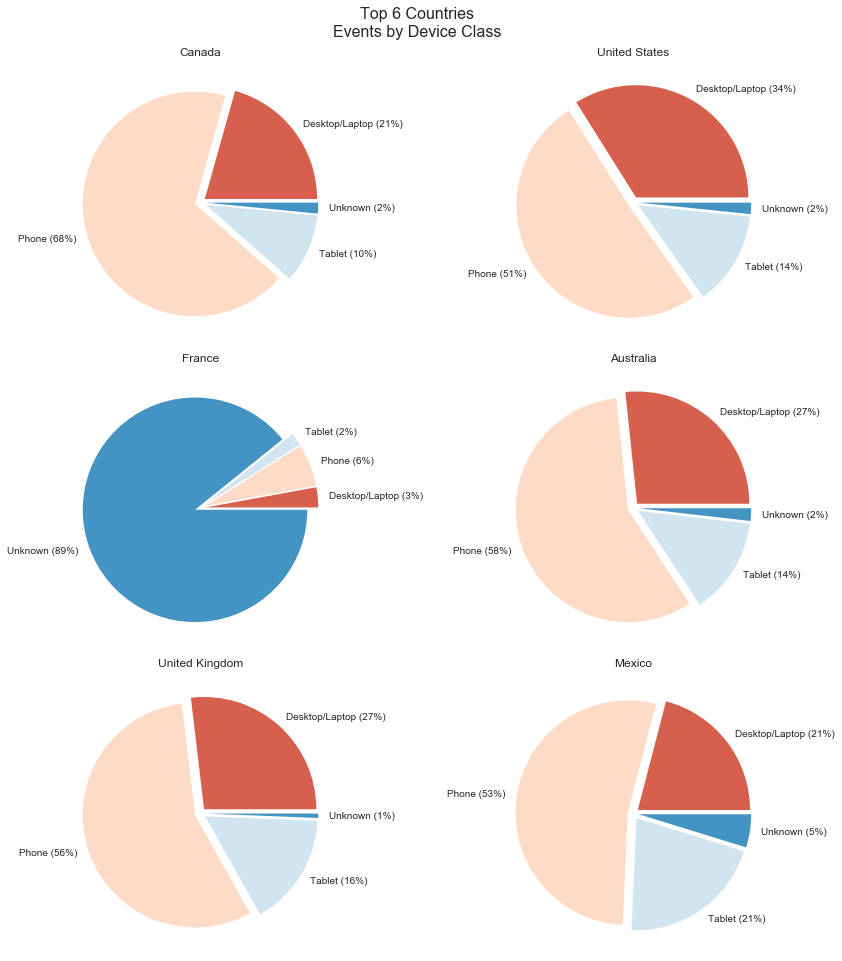

In [108]:
cmap_temp = sns.color_palette("RdBu", 4)

# find top 6 countries
countries = list(df.groupby('country').amplitude_id.nunique().sort_values(ascending=False)[:6].index)

# define number of subplots & columns
total_subplots = len(countries)
total_cols = 2

# determine the number of rows required
total_rows = total_subplots // total_cols
total_rows += total_subplots % total_cols

# setup subplot position
pos = range(1, total_subplots+1)

# create plot
fig = plt.figure(figsize=(14,14))
i=0

for country in countries:
    
    # get data
    data = df[df.country==country].groupby('device_class').amplitude_id.nunique().sort_index()
    
    # set values & labels
    data_values = data.sort_index().values
    data_labels = list(data.sort_index().index)
    
    # format data labels to include percentage
    data_labels = ['{} ({:.0%})'.format(i, data_values[data_labels.index(i)] / sum(data_values)) for i in data_labels]
    
    # explode pie a bit
    explode = [0.05 for i in data_labels]
    
    # create pie chart
    ax = fig.add_subplot(total_rows, total_cols, pos[i])
    ax.pie(data_values, radius=1, labels=data_labels,colors=cmap_temp, explode=explode)
    ax.set(aspect='equal')
    
    # add title
    ax.set_title(country)
    
    # increase subplot position
    i+=1

# add a subplot title
plt.suptitle('Top 6 Countries\nEvents by Device Class', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('../figures/device_consumption_per_country.png')

plt.show()       

## 5. Content Consumption by Content Area

### What type of content areas are being consumed?

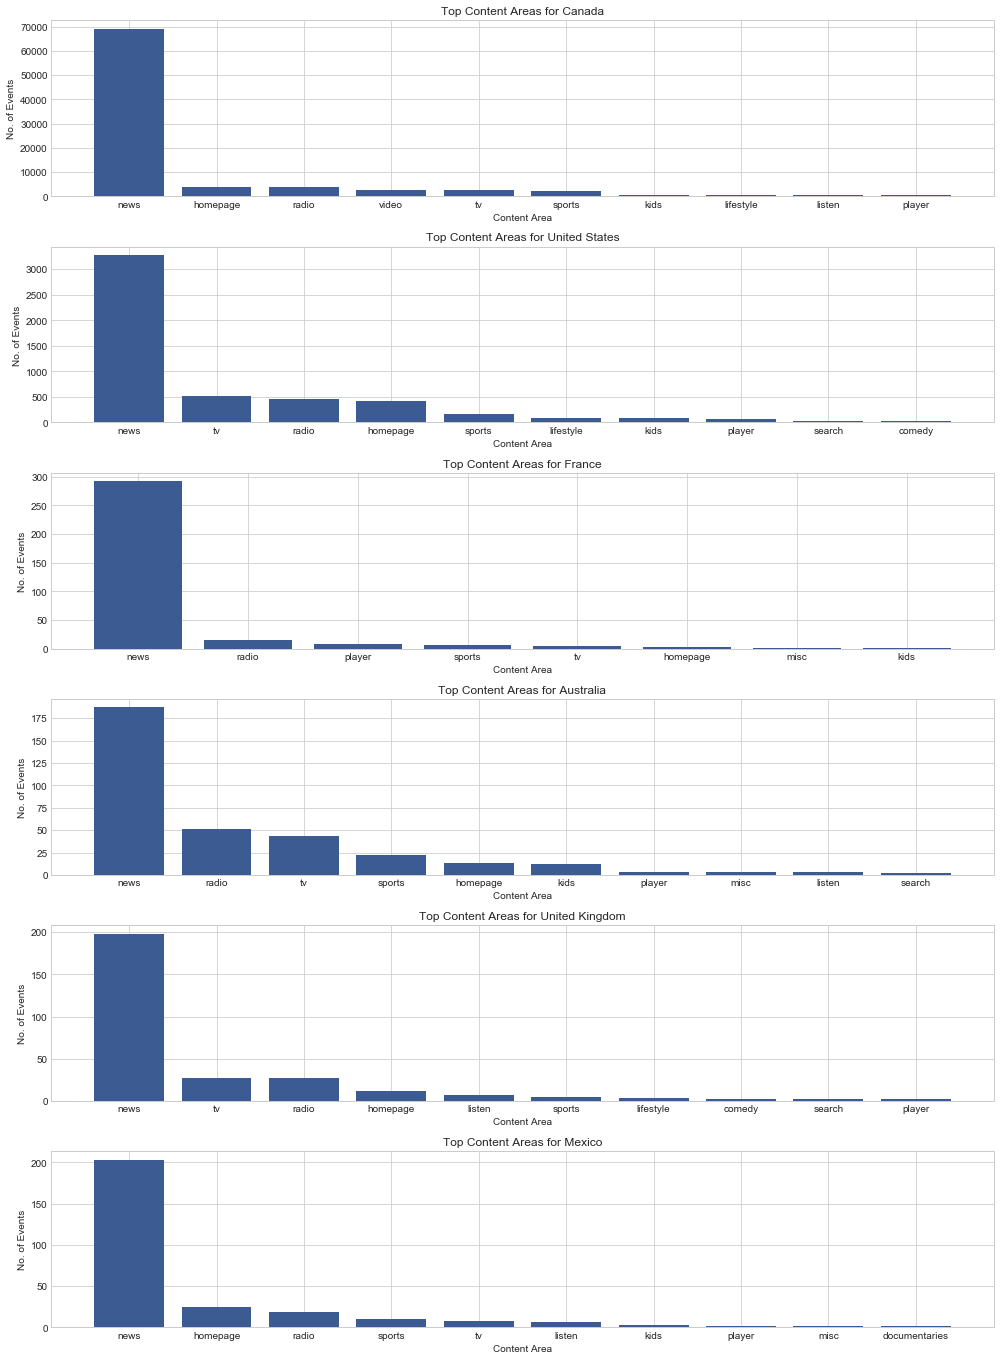

In [109]:
# find the content_area values that could be plotted
colour_index = list(df.content_area.unique())

# create colour map - a unique color per content area
cmap_temp = sns.color_palette("RdYlBu",len(colour_index))

# create subplots
fig, axs = plt.subplots(len(countries), figsize=(14,19))

# set plot location
i=0

# for each top country
for country in countries:
    
    # get data
    data = df[df.country==country].groupby('content_area').event_id.count().sort_values(ascending=False)[:10]
    
    # set values & labels
    data_values = data.values
    data_labels = list(data.index)
    
    colours = []
    
    # we will map each 'bar' to its respective content type colour
    for j in data_labels:
    
        # find colour mapped to this province name
        c = cmap_temp[colour_index.index(j)]

        # add the colour to our colours list
        colours.append(c)

    # create chart
    axs[i].bar(np.arange(len(data_labels)), data_values, color=deep_blue)
    
    # set ticks
    axs[i].set_xticks(np.arange(len(data_labels)))
    axs[i].set_xticklabels(data_labels)
    
    # set title
    axs[i].set_title('Top Content Areas for {}'.format(country))
    axs[i].set_ylabel('No. of Events')
    axs[i].set_xlabel('Content Area')
        
    # increase subplot position
    i+=1

plt.tight_layout()
plt.savefig('../figures/content_area_per_country.png')
plt.show()